In [56]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.13.0


## Import Data

In [57]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [58]:
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [59]:
df.shape

(398, 8)

In [60]:
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [61]:
df.dropna(inplace = True)

In [62]:
df.shape

(392, 8)

In [63]:
df.Origin.value_counts()

1    245
3     79
2     68
Name: Origin, dtype: int64

## Encoding Data

In [64]:
df['Origin'] = df['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [65]:
df.Origin.value_counts()

USA       245
Japan      79
Europe     68
Name: Origin, dtype: int64

In [66]:
df = pd.get_dummies(df, columns=['Origin'], prefix='', prefix_sep='')
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Splitting data

In [67]:
train_dataset = df.sample(frac=0.8, random_state=42)
test_dataset = df.drop(train_dataset.index)

In [68]:
print(train_dataset.shape, test_dataset.shape)

(314, 10) (78, 10)


In [69]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [70]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.153822,7.861854
Cylinders,5.531847,1.729449
Displacement,197.855096,106.501896
Horsepower,105.971338,39.636557
Weight,3005.745223,859.060925
Acceleration,15.510828,2.803560
Model Year,75.910828,3.688989
Europe,0.171975,0.377961
Japan,0.203822,0.403481
USA,0.624204,0.485101


## Normalize the data

In [71]:
normalizer = tf.keras.layers.Normalization()

In [72]:
normalizer.adapt(np.array(train_features))

In [73]:
print(normalizer.mean.numpy())

[[   5.532  197.855  105.971 3005.746   15.511   75.911    0.172    0.204
     0.624]]


In [74]:
np.array(train_features[:1])

array([[   4.,   96.,   69., 2189.,   18.,   72.,    1.,    0.,    0.]])

In [75]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.   96.   69. 2189.   18.   72.    1.    0.    0.]]

Normalized: [[-0.89 -0.96 -0.93 -0.95  0.89 -1.06  2.19 -0.51 -1.29]]


## Simple Linear Regression

### 1st Model

In [76]:
horsepower = np.array(train_features['Horsepower']) #[:, tf.newaxis]
horsepower_normalizer = layers.Normalization(input_shape=[1, ], axis=None)
horsepower_normalizer.adapt(horsepower)

In [77]:
horsepower_normalizer.mean

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([105.971], dtype=float32)>

In [78]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [79]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 71ms/step


array([[ 0.663],
       [-0.162],
       [ 0.824],
       [ 0.645],
       [ 0.358],
       [ 0.555],
       [-1.148],
       [ 0.555],
       [ 0.197],
       [ 1.021]], dtype=float32)

In [80]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [81]:
# np.array(train_features['Horsepower'])[:, tf.newaxis]

In [82]:
np.array(train_labels).shape

(314,)

In [83]:
%%time
history = horsepower_model.fit(
    np.array(train_features['Horsepower'])[:, tf.newaxis],
    np.array(train_labels),
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2   
)

CPU times: total: 6.22 s
Wall time: 5.44 s


In [84]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.905024,3.317240,95
96,3.904856,3.320971,96
97,3.904009,3.314157,97
98,3.906115,3.313151,98
99,3.906036,3.321305,99


In [85]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

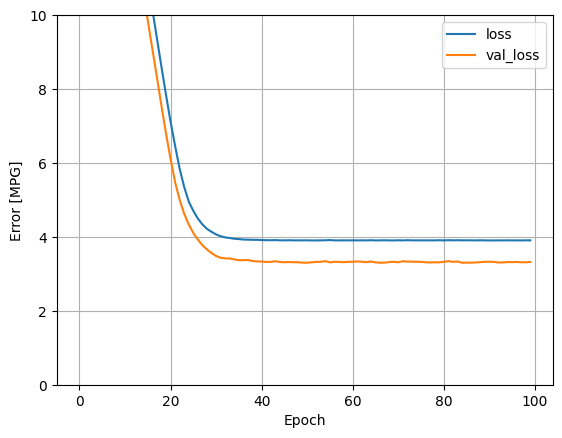

In [86]:
plot_loss(history)

In [87]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [88]:
test_results

{'horsepower_model': 3.938621759414673}

In [89]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [90]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

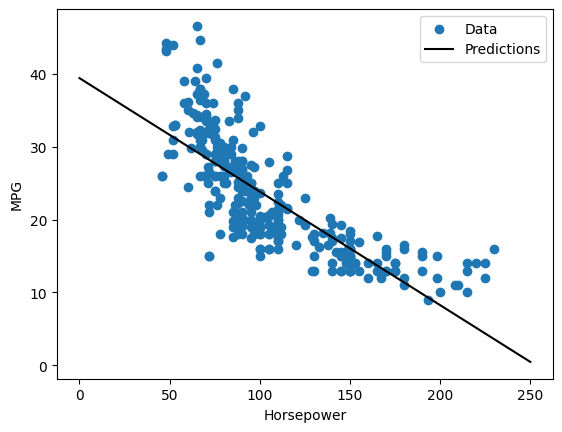

In [91]:
plot_horsepower(x, y)

### 2nd Model

In [92]:
normalizer.mean

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[   5.532,  197.855,  105.971, 3005.746,   15.511,   75.911,
           0.172,    0.204,    0.624]], dtype=float32)>

In [93]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [94]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [95]:
%%time
history = linear_model.fit(
    np.array(train_features),
    np.array(train_labels),
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 6.69 s
Wall time: 5.76 s


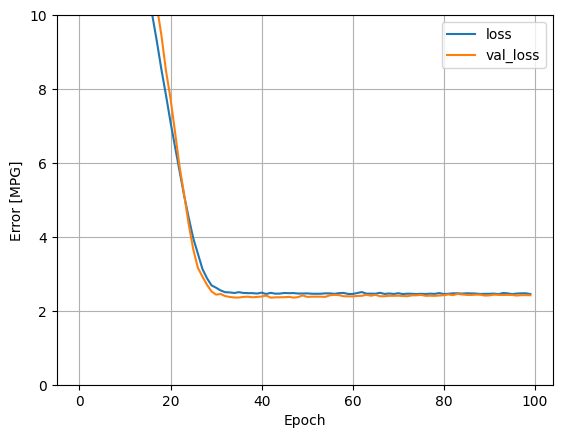

In [96]:
plot_loss(history)

In [97]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [98]:
test_results

{'horsepower_model': 3.938621759414673, 'linear_model': 2.51959490776062}

## Regression with DNN

In [99]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

### 1st Model

In [100]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [101]:
dnn_horsepower_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_10 (Dense)            (None, 64)                128       
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [102]:
%%time
history = dnn_horsepower_model.fit(
    np.array(train_features['Horsepower']),
    np.array(train_labels),
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 8.06 s
Wall time: 6.78 s


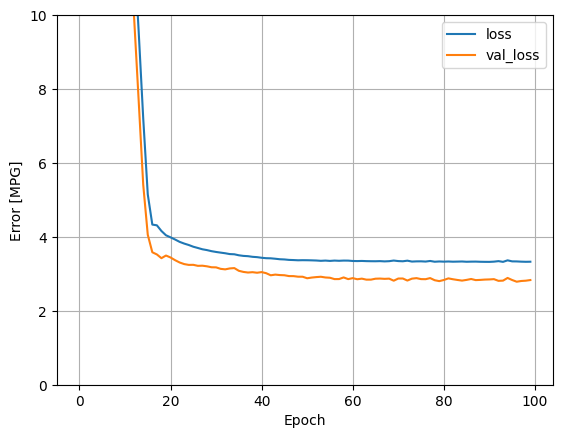

In [103]:
plot_loss(history)

In [104]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 1ms/step


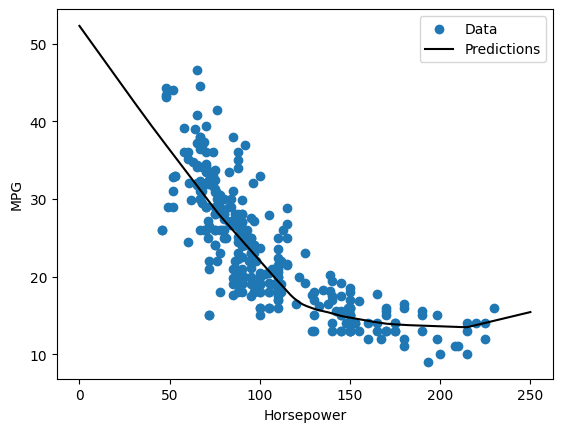

In [105]:
plot_horsepower(x, y)

In [106]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [107]:
test_results

{'horsepower_model': 3.938621759414673,
 'linear_model': 2.51959490776062,
 'dnn_horsepower_model': 3.4422364234924316}

### 2nd Model

In [108]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normaliza  (None, 9)                 19        
 tion)                                                           
                                                                 
 dense_13 (Dense)            (None, 64)                640       
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


In [109]:
%%time
history = dnn_model.fit(
    np.array(train_features),
    np.array(train_labels),
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 7.81 s
Wall time: 6.23 s


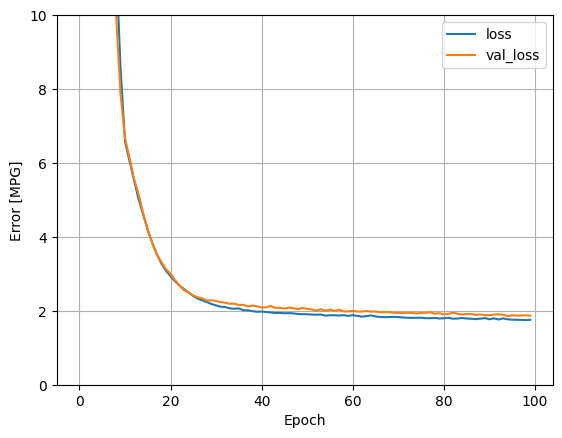

In [110]:
plot_loss(history)

In [111]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Predictions and Performance

In [112]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.938622
linear_model,2.519595
dnn_horsepower_model,3.442236
dnn_model,1.870340


3/3 [==============================] - 0s 2ms/step


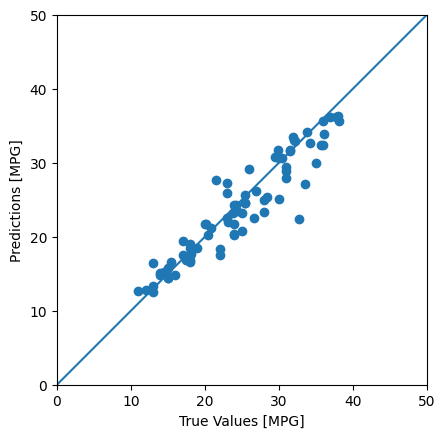

In [113]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)